# Evaluation of the actions

In [136]:
import logging
import numpy as np
import pandas as pd
import grid2op
import os
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Dict, List
from collections import defaultdict

from grid2op_env.utils import get_sub_id_to_action
from evaluation.utils import get_do_nothing

In [3]:
class AgentInfo:

    def __init__(self, actions, chronic_to_num, topo_vects, all_actions = None, do_nothing_actions = None, rewards = None, avg_time_per_step = None):
        self.actions = actions
        self.chronic_to_num = chronic_to_num
        self.topo_vects = topo_vects
        self.all_actions = all_actions
        self.do_nothing_actions = do_nothing_actions
        self.rewards = rewards
        self.avg_time_per_step = avg_time_per_step
    
    @property
    def action_to_sub_id(self):
        """
        Maps the actions to sub
        """
        return get_sub_id_to_action(self.all_actions)
    
    @property
    def mean_chronic_length(self):
        """
        Returns the mean length of the chronic
        """
        if isinstance(list(self.chronic_to_num.values())[0], list):
            return np.mean([steps[-1] for chronic,steps in self.chronic_to_num.items()])
        else: # ensure backward compatibility when the values were ints
            return np.mean(list(self.chronic_to_num.values()))
    @property
    def std_chronic_length(self):
        """
        Returns the mean length of the chronic
        """
        if isinstance(list(self.chronic_to_num.values())[0], list):
            return np.std([steps[-1] for chronic,steps in self.chronic_to_num.items()])
        else: # ensure backward compatibility when the values were ints
            return np.std(list(self.chronic_to_num.values()))

    @property
    def num_imperfect_chronics(self):

        # Get the list with the number of survived steps per chronic
        if isinstance(list(self.chronic_to_num.values())[0], list):
            num_step_chron=  [steps[-1] for chronic,steps in self.chronic_to_num.items()]
        else: # ensure backward compatibility when the values were ints
            num_step_chron = list(self.chronic_to_num.values())

        num_imperfect_chron = len([x for x in num_step_chron if x != 8064])
        
        return num_imperfect_chron


    def quantile_chronic_length(self, quantile = 0.5):
        """
        Returns the mean length of the chronic
        """
        if isinstance(list(self.chronic_to_num.values())[0], list):
            return np.quantile([steps[-1] for chronic,steps in self.chronic_to_num.items()], q = quantile)
        else: # ensure backward compatibility when the values were ints
            return np.quantile(list(self.chronic_to_num.values()), q = quantile)

    @property
    def substation_list(self):
        return list(self.action_to_sub_id.keys())
    

In [4]:
class ActionAnalysis:

    def __init__(self, actions:  Dict[int, List[grid2op.Action.BaseAction]]):
        self.actions = actions

    def order_chronics_per_activity(self):
        return dict(sorted(self.actions.items(),
                         key=lambda x: len(x[1]), reverse=True))

    def pop_implicit_no_op(self, topo_vects: Dict[int, List[np.array]], chronic_to_num_step =Dict[int, List[int]] )\
         -> Dict[int, List[grid2op.Action.BaseAction]]:
        """
        Removes action that do not change the topology.

        Parameters:
        -----------

        topo_vects: Dict[int, List[np.array]] 
        """
        
        actions_topo_change = defaultdict(list)
        chronic_to_num_topo_change = defaultdict(list)
        for chronic_id, topo_list in topo_vects.items():
            for ix, topo in enumerate(topo_list):
                if ix == 0:
                    actions_topo_change[chronic_id].append(self.actions[chronic_id][0])
                    chronic_to_num_topo_change[chronic_id].append(chronic_to_num_step[chronic_id][0])
                    continue
                #print(ix)
                if not np.array_equal(topo_list[ix-1], topo_list[ix]):
                    # if  self.actions[chronic_id][ix-1].as_dict() == self.actions[chronic_id][ix].as_dict():
                    #     print(f"Chronic {chronic_id} action {ix} is the same as action {ix-1} but the topology is different")
                    try:
                        actions_topo_change[chronic_id].append(self.actions[chronic_id][ix])
                        chronic_to_num_topo_change[chronic_id].append(chronic_to_num_step[chronic_id][ix])
                    except:
                        print(f"Mismatch in shape of topo_vects and action for chronic {chronic_id}. Skipping action from topo_vect {ix}")
                        
        
        self.actions_topo_change = actions_topo_change
        self.chronic_to_num_topo_change = chronic_to_num_topo_change
 
    @staticmethod
    def action_to_sub_id(actions:  Dict[int, List[grid2op.Action.BaseAction]]) \
            -> Dict[int, List[int]]:
        """
        Transforms the action in the chronic : list of actions dict
        into chronic : list of affected sub ids dict.

        Parameters:
        -----------

        actions: Dict[int, List[grid2op.Action.BaseAction]]
            The action dict.
        """
        grouped = defaultdict(list)
        for k, v in actions.items():
            for act in v:
                if act.as_dict() != {}: # do nothing 
                    modified_subs = act.as_dict()["set_bus_vect"]['modif_subs_id']
                    if len(modified_subs) > 1:
                     logging.warning("More than one substation modified. Choosing the first one.")
                    grouped[k].append(modified_subs[0])
                else:
                    grouped[k].append(-1)
        
        return grouped

    @staticmethod
    def substation_count(grouped: Dict[int, List[int]]) -> Dict[int, int]:
        """
        Given a dictionary with values being a list of affected substation ids
        returns a dictionary with keys being the substation ids
        and values number of actions that changed the substation.

        Parameters:
        -----------
        grouped: Dict[int, List[int]])
            Output of action_to_sub_id method.
        """
        count = defaultdict(int)
        for chronic_sub_list in grouped.values():
            for affected_sub in chronic_sub_list:
                count[affected_sub] += 1
        return count

    @staticmethod
    def count_actions(actions:Dict[int, List[grid2op.Action.BaseAction]]) \
         -> int:
        count = 0
        for k, v in actions.items():
            count += len(v)
        return count
    
    @staticmethod
    def get_unique_topos(topo_vects: Dict[int, List[np.array]]) \
         -> int:
        all_topos = []
        for chronic in topo_vects.keys():
            all_topos.append(topo_vects_[chronic])

        return np.unique(np.concatenate(all_topos), axis = 0, return_counts=True)

    @property
    def chronic_count(self):
        return len(self.actions)

## Run evaluation

In [2]:
#eval_path = "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/SAC_Grid_Gym_Greedy_02837_00001_1_num_workers=2,seed=49,train_batch_size=1024_2022-02-25_13-32-49"
# eval_path = "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/SAC_Grid_Gym_a77d3_00004_4_num_workers=14,seed=50_2022-02-18_00-14-03"
# EVAL_PATHS = {  "SAC": "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/SAC_Grid_Gym_a77d3_00004_4_num_workers=14,seed=50_2022-02-18_00-14-03",
#                 "SAC_Greedy":"/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/SAC_Grid_Gym_Greedy_02837_00001_1_num_workers=2,seed=49,train_batch_size=1024_2022-02-25_13-32-49",
#                 "PPO Native" : "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/PPO_Grid_Gym_2e2dd_00001_1_num_workers=6,seed=42_2022-02-17_20-24-19",
#                 "PPO Substation": "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/PPO_Grid_Gym_Greedy_5efc8_00007_7_num_workers=4,seed=23_2022-02-23_03-10-34",
#                 "Greedy": "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/greedy_PPO_Grid_Gym_2e2dd_00001_1_num_workers=6,seed=42_2022-02-17_20-24-19", 
#                 "SAC_Greedy_Entropy": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/SAC_Grid_Gym_Greedy_1e434_00000_0_initial_alpha=1.221,num_workers=8,prioritized_replay=True,seed=21_2022-03-08_15-00-32_70_1000_True", "1e434_00000")
#                  }

# Eval paths for models trained with train/val/test split
EVAL_PATHS = {"PPO Native": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/PPO_Grid_Gym_10803_00000_0_num_workers=6,seed=21_2022-03-12_08-00-13_90_test_chronics","10803_00000"),
                "PPO Substation": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/PPO_Grid_Gym_Greedy_154e3_00006_6_num_workers=6,seed=28_2022-03-12_22-22-53_90_test_chronics", "154e3_00006"),
                "SAC Native" : ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/SAC_Grid_Gym_190e1_00002_2_initial_alpha=1.221,num_workers=6,prioritized_replay=True,seed=50_2022-03-12_13-58-36_145_test_chronics", "190e1_00002" ),
                "SAC Substation" : ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/SAC_Grid_Gym_Greedy_1e1e2_00003_3_initial_alpha=1.35,num_workers=8,prioritized_replay=True,seed=42_2022-03-12_15-35-20_80_test_chronics", "1e1e2_00003"),
                "Greedy": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/greedy_PPO_Grid_Gym_10803_00000_0_num_workers=6,seed=21_2022-03-12_08-00-13_None_test_chronics", "10803_00000"),
                #"New SAC": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/SAC_Grid_Gym_Greedy_96d3e_00009_9_initial_alpha=1.105,num_workers=6,entropy_learning_rate=1e-20,seed=31,train_batch_size=1024_2022-03-15_18-53-48_40_test_chronics", "96d3e_00009"),
}

def get_analysis_objects(eval_path: str, wandb_run_id:str = None):

        if len(os.listdir(eval_path)) == 3: # backward compatibility
                running_deprecated_eval = True
                action_path, chronic_to_num_path, topo_vects_path  = sorted(os.listdir(eval_path), key = lambda x: x[0])

                actions, chronic_to_num, topo_vects = np.load(os.path.join(eval_path, action_path), allow_pickle=True).item(), \
                                                np.load(os.path.join(eval_path, chronic_to_num_path), allow_pickle=True).item(), \
                                                np.load(os.path.join(eval_path, topo_vects_path), allow_pickle=True).item()
        else:
                running_deprecated_eval = False
                actions, topo_vects, chronic_to_num, rewards, avg_time_per_step  = np.load(os.path.join(eval_path, "actions.npy"), allow_pickle=True).item(), \
                                                np.load(os.path.join(eval_path, "topo_vects.npy"), allow_pickle=True).item(), \
                                                np.load(os.path.join(eval_path, "chronic_to_num_steps.npy"), allow_pickle=True).item(), \
                                                np.load(os.path.join(eval_path, "rewards.npy"), allow_pickle=True).item(), \
                                                np.load(os.path.join(eval_path, "avg_time_per_step.npy"), allow_pickle=True).item()

        
        if wandb_run_id is None:
                wandb_run_id = "_".join(eval_path.split("_num_workers")[0].split("_")[-3:-1])#"_".join(EVAL_RESULTS_PATH.split("Grid_Gym_")[1].split("_")[0:2])

        do_nothing_actions, all_actions = get_do_nothing(wandb_run_id = wandb_run_id)
        
        agent_info = AgentInfo(actions, chronic_to_num, topo_vects, all_actions, do_nothing_actions, rewards, avg_time_per_step)
        
        print(f"Mean chronic length {agent_info.mean_chronic_length}")
        print(f"0.2 quantile chronic length {agent_info.quantile_chronic_length(0.25)}")
        action_analysis = ActionAnalysis(actions)

        if running_deprecated_eval:
                return agent_info, action_analysis, topo_vects, None, None
        else: 
                return agent_info, action_analysis, topo_vects, rewards, avg_time_per_step

def get_evaluation_data(eval_path: str, wandb_run_id:str = None):

        agent_info, action_analysis, topo_vects, rewards, avg_time_per_step = get_analysis_objects(eval_path, wandb_run_id)
        action_analysis.pop_implicit_no_op(topo_vects, agent_info.chronic_to_num)

        grouped = action_analysis.action_to_sub_id(action_analysis.actions) # needed for explicit do nothing
        grouped_topo_change = action_analysis.action_to_sub_id(action_analysis.actions_topo_change)

        sub_num_actions = action_analysis.substation_count(grouped_topo_change)
        sub_num_actions_all = action_analysis.substation_count(grouped)

        sub_num_actions["10000"] = abs(sub_num_actions_all["0"] - \
                (action_analysis.count_actions(action_analysis.actions) -  action_analysis.count_actions(action_analysis.actions_topo_change)))


        # Add the substations without any actions
        for sub in agent_info.substation_list:
                if str(sub) not in sub_num_actions:
                        sub_num_actions[str(sub)] = 0

        sub_num_actions["20000"] = sub_num_actions_all["0"]
        sub_num_actions.pop("0", None)

        sub_num_actions = dict(sorted(sub_num_actions.items(), key = lambda x: float(x[0])  ))

        sub_num_actions["Implict No op"] = sub_num_actions["10000"] 
        sub_num_actions["Explicit No op"] = sub_num_actions["20000"]  

        sub_num_actions.pop("10000", None)
        sub_num_actions.pop("20000", None)

        num_actions = sum(sub_num_actions.values())
        normalized_sub_num_actions = {key: value/num_actions for key, value in sub_num_actions.items()}

        leave_keys = ['1', '2', '3', '4', '5', '8', '12', 'Implict No op', 'Explicit No op']
        for key, val in sub_num_actions.items():
                if key not in leave_keys:
                        normalized_sub_num_actions.pop(key, None)

        print(f"Normalized substation actions {normalized_sub_num_actions}")
        return normalized_sub_num_actions, num_actions, action_analysis.actions_topo_change, agent_info, action_analysis



In [6]:
data_per_algorithm = {} 

In [7]:
for name, path in EVAL_PATHS.items():
    if name not in data_per_algorithm:
        if isinstance(path, tuple):
            path, wandb_run_id = path
        else: 
            wandb_run_id = None
        print(f"Processing name {name} ")
        normalized_sub_num_actions, num_actions, actions_topo_change,  agent_info, action_analysis = get_evaluation_data(path,wandb_run_id )
        # if name not in data_per_algorithm:
        data_per_algorithm[name] = {} 
        data_per_algorithm[name]["action_distr"] = normalized_sub_num_actions
        print(data_per_algorithm[name]["action_distr"])
        data_per_algorithm[name]["num_actions"] = num_actions
        data_per_algorithm[name]["actions_topo_change"] = actions_topo_change
        print(data_per_algorithm[name]["action_distr"])

        data_per_algorithm[name]["agent_info"] = agent_info
        data_per_algorithm[name]["action_analysis"] = action_analysis
    else:
        continue
    

Processing name PPO Native 
The environment has 700 chronics.
Mean chronic length 8013.085
0.2 quantile chronic length 8064.0


Exception ignored in: <function GymEnv.__del__ at 0x7fa5513c1200>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


Normalized substation actions {'1': 0.009734142767427255, '2': 0.0, '3': 0.41971948921917523, '4': 0.0, '5': 0.0, '8': 0.021247644965459493, '12': 0.0, 'Implict No op': 0.5491940548461377, 'Explicit No op': 0.00010466820180029308}
{'1': 0.009734142767427255, '2': 0.0, '3': 0.41971948921917523, '4': 0.0, '5': 0.0, '8': 0.021247644965459493, '12': 0.0, 'Implict No op': 0.5491940548461377, 'Explicit No op': 0.00010466820180029308}
{'1': 0.009734142767427255, '2': 0.0, '3': 0.41971948921917523, '4': 0.0, '5': 0.0, '8': 0.021247644965459493, '12': 0.0, 'Implict No op': 0.5491940548461377, 'Explicit No op': 0.00010466820180029308}
Processing name PPO Substation 
The environment has 700 chronics.
Mean chronic length 8064.0
0.2 quantile chronic length 8064.0


Exception ignored in: <function GymEnv.__del__ at 0x7fa5513c1200>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


Normalized substation actions {'1': 0.0, '2': 0.0, '3': 0.33270998909147576, '4': 0.0, '5': 0.0, '8': 0.07137291569269129, '12': 0.0, 'Implict No op': 0.5959170952158329, 'Explicit No op': 0.0}
{'1': 0.0, '2': 0.0, '3': 0.33270998909147576, '4': 0.0, '5': 0.0, '8': 0.07137291569269129, '12': 0.0, 'Implict No op': 0.5959170952158329, 'Explicit No op': 0.0}
{'1': 0.0, '2': 0.0, '3': 0.33270998909147576, '4': 0.0, '5': 0.0, '8': 0.07137291569269129, '12': 0.0, 'Implict No op': 0.5959170952158329, 'Explicit No op': 0.0}
Processing name SAC Native 
The environment has 700 chronics.
Mean chronic length 7769.975
0.2 quantile chronic length 8064.0


Exception ignored in: <function GymEnv.__del__ at 0x7fa5513c1200>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


Normalized substation actions {'1': 0.007052129663020395, '2': 0.0, '3': 0.0054493729214248506, '4': 0.0, '5': 0.00016027567415955444, '8': 0.008013783707977722, '12': 0.0, 'Implict No op': 0.9793244380334175, 'Explicit No op': 0.0}
{'1': 0.007052129663020395, '2': 0.0, '3': 0.0054493729214248506, '4': 0.0, '5': 0.00016027567415955444, '8': 0.008013783707977722, '12': 0.0, 'Implict No op': 0.9793244380334175, 'Explicit No op': 0.0}
{'1': 0.007052129663020395, '2': 0.0, '3': 0.0054493729214248506, '4': 0.0, '5': 0.00016027567415955444, '8': 0.008013783707977722, '12': 0.0, 'Implict No op': 0.9793244380334175, 'Explicit No op': 0.0}
Processing name SAC Substation 
The environment has 700 chronics.
Mean chronic length 7821.42
0.2 quantile chronic length 8064.0


Exception ignored in: <function GymEnv.__del__ at 0x7fa5513c1200>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


Normalized substation actions {'1': 0.0, '2': 0.0, '3': 0.0002122961956521739, '4': 0.010062839673913044, '5': 0.0, '8': 0.08636209239130435, '12': 0.0, 'Implict No op': 0.9033627717391305, 'Explicit No op': 0.0}
{'1': 0.0, '2': 0.0, '3': 0.0002122961956521739, '4': 0.010062839673913044, '5': 0.0, '8': 0.08636209239130435, '12': 0.0, 'Implict No op': 0.9033627717391305, 'Explicit No op': 0.0}
{'1': 0.0, '2': 0.0, '3': 0.0002122961956521739, '4': 0.010062839673913044, '5': 0.0, '8': 0.08636209239130435, '12': 0.0, 'Implict No op': 0.9033627717391305, 'Explicit No op': 0.0}
Processing name Greedy 
The environment has 700 chronics.
Mean chronic length 7793.185
0.2 quantile chronic length 8064.0


Exception ignored in: <function GymEnv.__del__ at 0x7fa5513c1200>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


Normalized substation actions {'1': 0.2787416896383979, '2': 0.0056753688989784334, '3': 0.15680233500891844, '4': 0.1250202691746392, '5': 0.012647964974866224, '8': 0.05545646181287498, '12': 0.0, 'Implict No op': 0.00016215339711366953, 'Explicit No op': 0.3654937570942111}
{'1': 0.2787416896383979, '2': 0.0056753688989784334, '3': 0.15680233500891844, '4': 0.1250202691746392, '5': 0.012647964974866224, '8': 0.05545646181287498, '12': 0.0, 'Implict No op': 0.00016215339711366953, 'Explicit No op': 0.3654937570942111}
{'1': 0.2787416896383979, '2': 0.0056753688989784334, '3': 0.15680233500891844, '4': 0.1250202691746392, '5': 0.012647964974866224, '8': 0.05545646181287498, '12': 0.0, 'Implict No op': 0.00016215339711366953, 'Explicit No op': 0.3654937570942111}


Check the what are the most active chronics, just out of curiosity:

In [8]:
# import numpy as np

# _, action_analysis, topo_vects = get_analysis_objects(eval_path = "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/greedy_PPO_Grid_Gym_2e2dd_00001_1_num_workers=6,seed=42_2022-02-17_20-24-19")
# action_analysis.pop_implicit_no_op(topo_vects)

# chronics_sorted_len = dict(sorted(action_analysis.actions_topo_change.items(),
#                          key=lambda x: len(x[1]), reverse=True))  #.keys()

# np.random.seed(0)

# def chunks(lst, n):
#     """Yield successive n-sized chunks from lst."""
#     for i in range(0, len(lst), n):
#         yield np.array(lst[i:i + n])

# # Account for chronic id's being shifted by 1
# sorted_chronics = [chronic_id-1 for chronic_id in list(chronics_sorted_len.keys())]

# splits = [0.7,0.1,0.2]
# train_chronics, val_chronics, test_chronics = [], [], []
# for chunk in chunks(sorted_chronics, 100):
#     train_size, val_size, test_size = [int(len(chunk) * split ) for split in splits]
#     indices = np.random.permutation(len(chunk))
#     train_indices, val_indices, test_indices = indices[:train_size], indices[train_size:train_size + val_size], indices[train_size + val_size:]

#     train_chronics.append(chunk[train_indices])
#     val_chronics.append(chunk[val_indices])
#     test_chronics.append(chunk[test_indices])
#     # val_chronics, test_chronics = chunk[train_indices], chunk[val_indices], chunk[test_indices]

# train_chronics = np.array(train_chronics).flatten()
# val_chronics = np.array(val_chronics).flatten()
# test_chronics = np.array(test_chronics).flatten()

# # Test 

# for chunk in chunks(sorted_chronics,100):
#     num_from_chunk_train = 0
#     num_from_chunk_val = 0
#     num_from_chunk_test = 0
#     for elem in chunk:
#         if elem in train_chronics:
#             num_from_chunk_train += 1
#             assert elem not in val_chronics
#             assert elem not in test_chronics
#         if elem in val_chronics:
#             num_from_chunk_val += 1
#             assert elem not in train_chronics
#             assert elem not in test_chronics
#         if elem in test_chronics:
#             num_from_chunk_test += 1
#             assert elem not in train_chronics
#             assert elem not in val_chronics
    
#     assert num_from_chunk_train + num_from_chunk_val + num_from_chunk_test == len(chunk)
#     assert num_from_chunk_train == 70
#     assert num_from_chunk_val == 10
#     assert num_from_chunk_test == 20


# # np.save("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/grid2op_env/train_val_test_split/train_chronics.npy", train_chronics)
# # np.save("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/grid2op_env/train_val_test_split/val_chronics.npy", val_chronics)
# # np.save("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/grid2op_env/train_val_test_split/test_chronics.npy", test_chronics)
 

### Compile the dataframe from which we will later plot the results

In [112]:
df_dict = {}
for name, value in data_per_algorithm.items():
    df_dict[name] = {}
    for key, val in value.items():
        if key in ["actions_topo_change", "agent_info", "action_analysis"]:
            continue
        if type(val) == dict:
            for sub_num, prop_actions in val.items():
                df_dict[name][sub_num] = prop_actions
        else:
            print(key)
            df_dict[name][key] = val

    df_dict[name]["num_topo_actions"] = df_dict[name]["num_actions"] * (1 - df_dict[name]["Implict No op"] - df_dict[name]["Explicit No op"] )  # actions that change the topology
    
    # Ensure backward compatibility
    if isinstance(data_per_algorithm[name]["agent_info"].mean_chronic_length, list):
        df_dict[name]["mean_chronic_length"] = data_per_algorithm[name]["agent_info"].mean_chronic_length[0]

    df_dict[name]["mean_chronic_length"] = data_per_algorithm[name]["agent_info"].mean_chronic_length
    df_dict[name]["std_chronic_length"] = data_per_algorithm[name]["agent_info"].std_chronic_length
    df_dict[name]["mean_normalized_reward"] = (np.mean(list(data_per_algorithm[name]["agent_info"].rewards.values())) / df_dict[name]["mean_chronic_length"] ) * 8064
    
    df_dict[name]["0.05th_quantile "] = data_per_algorithm[name]["agent_info"].quantile_chronic_length(0.05)
    df_dict[name]["num_imperfect_chron"] = data_per_algorithm[name]["agent_info"].num_imperfect_chronics
    # df_dict[name]["0.1th_quantile "] = data_per_algorithm[name]["agent_info"].quantile_chronic_length(0.1)
    # df_dict[name]["0.2th_quantile "] = data_per_algorithm[name]["agent_info"].quantile_chronic_length(0.2)
    # df_dict[name]["median_chronic_length"] = data_per_algorithm[name]["agent_info"].quantile_chronic_length(0.5)

df = pd.DataFrame.from_dict(df_dict, orient='index')#.reset_index()
df["No Op"] = df["Explicit No op"] + df["Implict No op"]
df

num_actions
num_actions
num_actions
num_actions
num_actions


,1,2,3,4,5,8,12,Implict No op,Explicit No op,num_actions,num_topo_actions,mean_chronic_length,std_chronic_length,mean_normalized_reward,0.05th_quantile,num_imperfect_chron,No Op
PPO Native,0.009734,0.000000,0.419719,0.000000,0.000000,0.021248,0.0,0.549194,0.000105,9554,4306.0,8013.085,483.150233,6876.787473,8064.0,6,0.549299
PPO Substation,0.000000,0.000000,0.332710,0.000000,0.000000,0.071373,0.0,0.595917,0.000000,6417,2593.0,8064.000,0.000000,6882.151625,8064.0,0,0.595917
SAC Native,0.007052,0.000000,0.005449,0.000000,0.000160,0.008014,0.0,0.979324,0.000000,24957,516.0,7769.975,1113.788007,6864.470174,5132.9,18,0.979324
SAC Substation,0.000000,0.000000,0.000212,0.010063,0.000000,0.086362,0.0,0.903363,0.000000,23552,2276.0,7821.420,1038.643068,6860.191710,7053.2,15,0.903363
Greedy,0.278742,0.005675,0.156802,0.125020,0.012648,0.055456,0.0,0.000162,0.365494,6167,3912.0,7793.185,1004.962542,6829.819154,5388.8,19,0.365656


### Mean chronic length plus + number of actions that change the topology

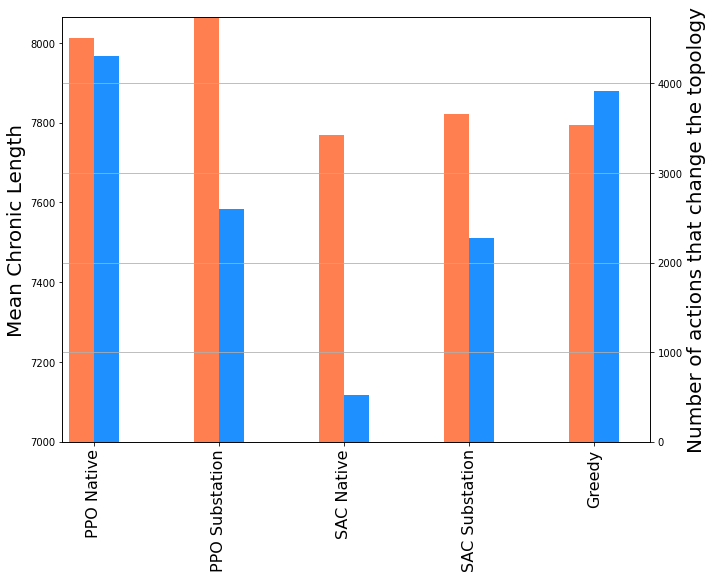

In [35]:
fig = plt.figure(figsize=(10,8), tight_layout=True) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.2
colors = sns.color_palette('pastel')

df.mean_chronic_length.plot(kind='bar', color='coral', ax=ax, width=width, position=1)
df.num_topo_actions.plot(kind='bar', color='dodgerblue', ax=ax2, width=width, position=0)

ax.set_ylabel('Mean Chronic Length', size = 20)
ax2.set_ylabel('Number of actions that change the topology', size = 20)

ax.set_ylim(7000, 8064)
ax2.set_ylim(0, df.num_topo_actions.max()*1.1)

ax.set_xticklabels(df.index, fontsize=16)

plt.grid(axis = "y")
plt.show()


#ax.get_figure().savefig("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/figures/performance_agents_test_split.jpg", dpi = 200)
#plt.savefig()

### Aggregated substation actions

-0.2
-0.1
0.0
0.1
0.2


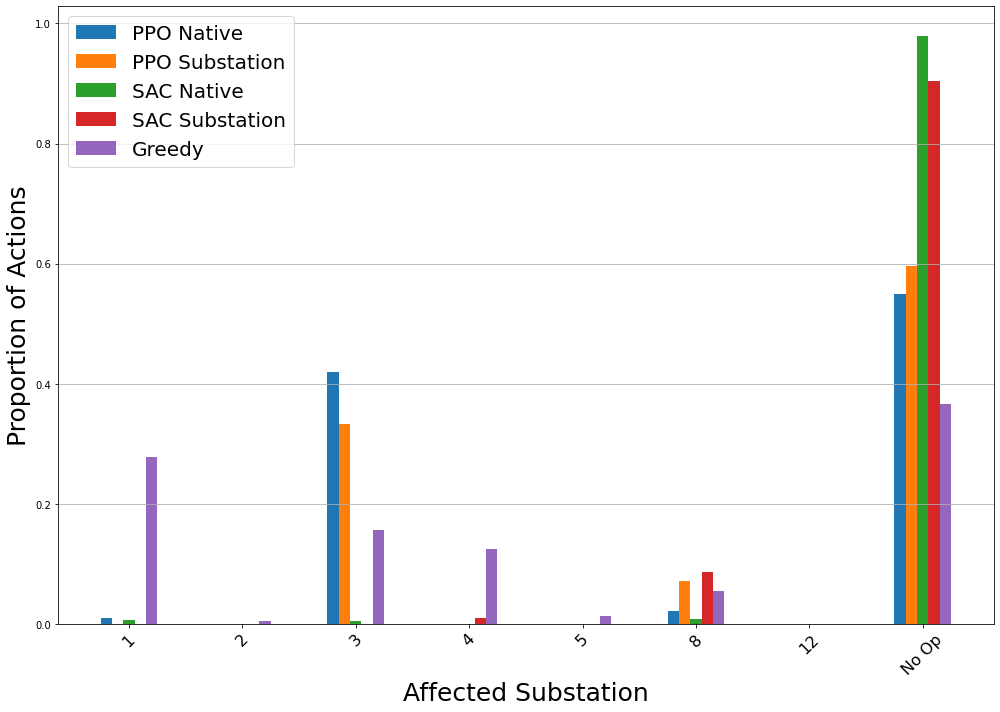

In [37]:
%matplotlib inline


# cols_this_plot = [str(elem) for elem in [1,2,3,4,5,8,12, "Implict No op", "Explicit No op"]]
cols_this_plot = [str(elem) for elem in [1,2,3,4,5,8,12, "No Op"]]



X_axis = np.arange(df.loc[df.index[0]][cols_this_plot].shape[0])
ax = plt.figure(figsize=(14,10), tight_layout=True)
colors = sns.color_palette('pastel')
offset = 0.1
for i, algo_type in enumerate(df.index):
    print((i - len(df.index)//2)*offset)
    plt.bar(X_axis + (i - len(df.index)//2)*offset , df.loc[algo_type][cols_this_plot], 0.1, label = algo_type)
    #plt.bar(X_axis + 0.2, df.loc["PPO Substaion"][:-1], 0.4, label = 'PPO Substation')

plt.xticks(X_axis, df.loc[df.index[0]][cols_this_plot].index, rotation = 45)

plt.xticks(fontsize=16)
plt.xlabel('Affected Substation', size = 25)
plt.ylabel('Proportion of Actions', size = 25)
#plt.title('Behaviours of different agents', size = 24)
plt.legend( prop={'size': 20})
plt.grid(axis = "y")
plt.show()

# ax.get_figure().savefig("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/figures/affected_substation_distr_test_split.jpg", dpi = 200)
#plt.savefig()

# ax.savefig("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/figures/behaviour_agents.jpg", dpi = 200)

### Aggregated substation actions excluding no op and normalized

-0.2
-0.1
0.0
0.1
0.2


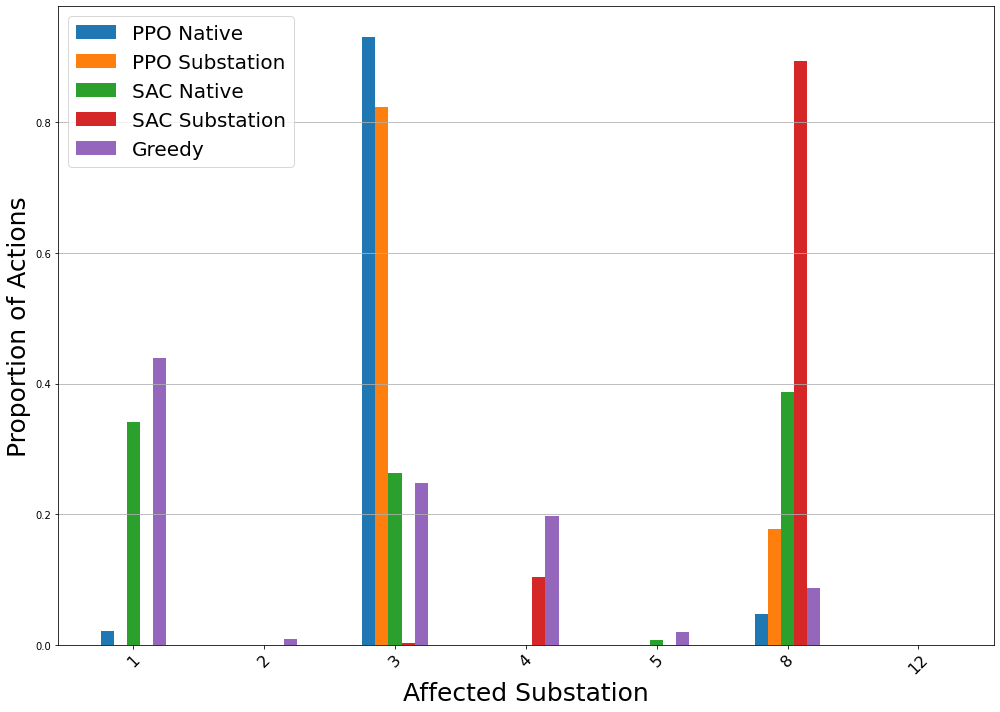

In [25]:
%matplotlib inline


# cols_this_plot = [str(elem) for elem in [1,2,3,4,5,8,12, "Implict No op", "Explicit No op"]]
df_op = df[["1", "2","3", "4", "5", "8", "12"]].div(df[["1", "2","3", "4", "5", "8", "12"]].sum(axis=1), axis=0)
cols_this_plot = [str(elem) for elem in [1,2,3,4,5,8,12]]



X_axis = np.arange(df_op.loc[df_op.index[0]][cols_this_plot].shape[0])
ax = plt.figure(figsize=(14,10), tight_layout=True)
colors = sns.color_palette('pastel')
offset = 0.1
for i, algo_type in enumerate(df_op.index):
    print((i - len(df_op.index)//2)*offset)
    plt.bar(X_axis + (i - len(df_op.index)//2)*offset , df_op.loc[algo_type][cols_this_plot], 0.1, label = algo_type)
    #plt.bar(X_axis + 0.2, df_op.loc["PPO Substaion"][:-1], 0.4, label = 'PPO Substation')

plt.xticks(X_axis, df_op.loc[df_op.index[0]][cols_this_plot].index, rotation = 45)

plt.xticks(fontsize=16)
plt.xlabel('Affected Substation', size = 25)
plt.ylabel('Proportion of Actions', size = 25)
#plt.title('Behaviours of different agents', size = 24)
plt.legend( prop={'size': 20})
plt.grid(axis = "y")
plt.show()

ax.get_figure().savefig("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/figures/affected_substation_distr_op_test_split.jpg", dpi = 200)
#plt.savefig()

# ax.savefig("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/figures/behaviour_agents.jpg", dpi = 200)

-0.6000000000000001
-0.4
-0.2
0.0
0.2
0.4


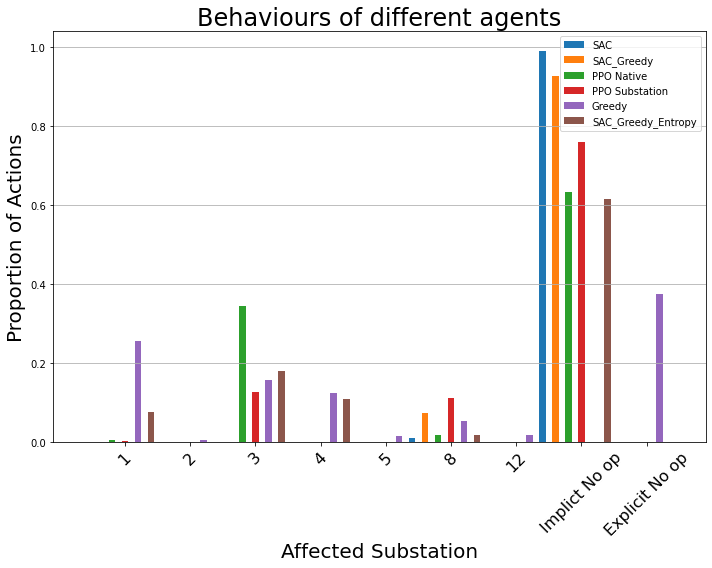

In [262]:
%matplotlib inline


cols_this_plot = [str(elem) for elem in [1,2,3,4,5,8,12, "Implict No op", "Explicit No op"]]

X_axis = np.arange(df.loc[df.index[0]][cols_this_plot].shape[0])
ax = plt.figure(figsize=(10,8), tight_layout=True)
colors = sns.color_palette('pastel')
offset = 0.2
for i, algo_type in enumerate(df.index):
    print((i - len(df.index)//2)*offset)
    plt.bar(X_axis + (i - len(df.index)//2)*offset , df.loc[algo_type][cols_this_plot], 0.1, label = algo_type)
    #plt.bar(X_axis + 0.2, df.loc["PPO Substaion"][:-1], 0.4, label = 'PPO Substation')

plt.xticks(X_axis, df.loc[df.index[0]][cols_this_plot].index, rotation = 45)

plt.xticks(fontsize=16)
plt.xlabel('Affected Substation', size = 20)
plt.ylabel('Proportion of Actions', size = 20)
plt.title('Behaviours of different agents', size = 24)
plt.legend()
plt.grid(axis = "y")
plt.show()


# ax.savefig("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/figures/behaviour_agents.jpg", dpi = 200)

### Number of unique actions taken
Note that this is equal to counting unique topologies.

In [118]:
number_of_unique_actions = defaultdict(int)

for algo_type in data_per_algorithm.keys():
    all_topos = np.concatenate(list(data_per_algorithm[algo_type]["agent_info"].topo_vects.values()))
   # all_topos all_topos
    unique_topos = np.unique(all_topos
                           , axis=0 )#.shape[0]
    print(algo_type, unique_topos.shape)
    # Filter out the disconnected lines
    unique_topos = unique_topos[(unique_topos>=1).all(axis=1)]
    df.loc[algo_type, "num_unique_topos"] = unique_topos.shape[0] # -1 to account for all disconnected 
      


PPO Native (55, 56)
PPO Substation (49, 56)
SAC Native (14, 56)
SAC Substation (77, 56)
Greedy (1590, 56)


In [119]:
all_topos_sub = np.concatenate(list(data_per_algorithm["PPO Substation"]["agent_info"].topo_vects.values()))
# all_topos all_topos
unique_topos_sub = np.unique(all_topos
                        , axis=0 )#.shape[0]
all_topos_native = np.concatenate(list(data_per_algorithm["PPO Native"]["agent_info"].topo_vects.values()))
# all_topos all_topos
unique_topos_native = np.unique(all_topos
                        , axis=0 )#.shape[0]

### Topological depth

In [120]:
mean_topo_depth = defaultdict(list)
for algo_type in data_per_algorithm.keys():
    topo_vects = data_per_algorithm[algo_type]["agent_info"].topo_vects
    for chronic, topo_vects_chronic in topo_vects.items():
        mean_topo_depth[algo_type].append(np.mean
                                    (np.sum(
                                            np.array(topo_vects_chronic) - 1, axis = 1)
                                            )
            )
    df.loc[algo_type, "mean_topo_depth"] = np.mean(mean_topo_depth[algo_type])
    df.loc[algo_type, "std_topo_depth"] = np.std(mean_topo_depth[algo_type])
    
    

### Action sequences


In [122]:
from tqdm import tqdm 

def get_action_sequences(algo_type, data_per_algorithm):
    """
    Reutrns a dictionary of 
    """

    def process_single_chronic(chronic_to_num_arr):
        """
        Returns a nested list of indicies of the actions that are part of the same sequence.
        
        """
        time_step_diff = np.diff(chronic_to_num_arr) == 1
        concat_val = True if time_step_diff[0] else False
        time_step_diff_match_dim = np.concatenate(([concat_val], time_step_diff))
        
        # Seperate different sequences
        sequences = []
        temp_seq = []
        new_seq = False
        for i, boolean in enumerate(time_step_diff_match_dim):
            if boolean:
                if len(temp_seq) == 0 and i > 0: # add the action that starts the sequence
                    temp_seq.append(chronic_to_num_arr[i-1])
                temp_seq.append(chronic_to_num_arr[i])

            else: # if not boolean:
                new_seq = True
                if len(temp_seq) > 0:
                    sequences.append(temp_seq)
                    temp_seq = []
        
        return sequences

    sequence_dict = defaultdict(int) # key: a tuple of topological vectors (tuples), values: count
    count_chrons = 0
    count_sequences = 0

    for chronic_id in tqdm(data_per_algorithm[algo_type]["agent_info"].chronic_to_num.keys()):
    # for chronic_id in tqdm([2]):
        chronic_to_num_arr = [elem -1 for elem in data_per_algorithm[algo_type]["action_analysis"].chronic_to_num_topo_change[chronic_id]]  #.pop("Greedy") #np.array([1,2,4,5, 7,8,9, 13, 20,21, 1998, 2002])
        if len(chronic_to_num_arr) < 2:
            continue
        count_chrons += 1
        sequences = process_single_chronic(chronic_to_num_arr)
        count_sequences += len(sequences)
        temp_seq = []

        chron_to_topo_dict = dict(zip(
            data_per_algorithm[algo_type]["agent_info"].chronic_to_num[chronic_id][:-1], data_per_algorithm[algo_type]["agent_info"].topo_vects[chronic_id]))
        # Match the keys of chron_to_topo_dict and chronic_to_num_arr by shifting the keys by one to the left
        chron_to_topo_dict = {key-1: chron_to_topo_dict[key] for key in chron_to_topo_dict.keys()}
         
        for seq in sequences:
            temp_seq = []
            for timestep in seq:
        
                temp_seq.append(tuple(chron_to_topo_dict[timestep]))
                if len(temp_seq) > 1:
                    assert temp_seq[-1] != temp_seq[-2]
            assert len(temp_seq) == len(seq)

            if tuple(temp_seq) in sequence_dict:
                sequence_dict[tuple(temp_seq)] += 1
            else:
                sequence_dict[tuple(temp_seq)] = 1
        
    assert count_sequences == sum(sequence_dict.values()), "Count of sequences does not match the count in the dictionary"
    print(count_sequences, sum(sequence_dict.values()))
    sequence_dict = dict(sorted(sequence_dict.items(),
                         key=lambda x: (x[1],len(x[0])), reverse=True))
    return sequence_dict



for algo_type in data_per_algorithm.keys():
    out = get_action_sequences(algo_type, data_per_algorithm)
    df.loc[algo_type, "mean_repeat_seq"] = np.mean(list(out.values()) )
    df.loc[algo_type, "std_repeat_seq"] = np.std(list(out.values()))
    df.loc[algo_type, "num_unqiue_seq"] = len(out)
    

df

100%|██████████| 200/200 [00:00<00:00, 8242.95it/s]


1024 1024


100%|██████████| 200/200 [00:00<00:00, 34030.86it/s]


30 30


100%|██████████| 200/200 [00:00<00:00, 28681.94it/s]


1 1


100%|██████████| 200/200 [00:00<00:00, 19023.94it/s]


189 189


100%|██████████| 200/200 [00:00<00:00, 25732.72it/s]

186 186


,1,2,3,4,5,8,12,Implict No op,Explicit No op,num_actions,...,mean_normalized_reward,0.05th_quantile,num_imperfect_chron,No Op,mean_repeat_seq,std_repeat_seq,num_unqiue_seq,num_unique_topos,mean_topo_depth,std_topo_depth
PPO Native,0.009734,0.000000,0.419719,0.000000,0.000000,0.021248,0.0,0.549194,0.000105,9554,...,6876.787473,8064.0,6,0.549299,5.019608,14.832384,204.0,49.0,4.162145,1.090222
PPO Substation,0.000000,0.000000,0.332710,0.000000,0.000000,0.071373,0.0,0.595917,0.000000,6417,...,6882.151625,8064.0,0,0.595917,1.250000,0.661438,24.0,49.0,3.601929,0.753775
SAC Native,0.007052,0.000000,0.005449,0.000000,0.000160,0.008014,0.0,0.979324,0.000000,24957,...,6864.470174,5132.9,18,0.979324,1.000000,0.000000,1.0,9.0,3.859013,1.218103
SAC Substation,0.000000,0.000000,0.000212,0.010063,0.000000,0.086362,0.0,0.903363,0.000000,23552,...,6860.191710,7053.2,15,0.903363,4.021277,5.748226,47.0,65.0,2.288617,0.924759
Greedy,0.278742,0.005675,0.156802,0.125020,0.012648,0.055456,0.0,0.000162,0.365494,6167,...,6829.819154,5388.8,19,0.365656,1.056818,0.296109,176.0,1587.0,5.427656,1.917530


In [123]:
# Check if the 

out = get_action_sequences("PPO Substation", data_per_algorithm)
# out.keys()


100%|██████████| 200/200 [00:00<00:00, 33194.60it/s]

30 30


### Get the df ready as a Latex table

In [169]:
include_cols = [
     ('num_topo_actions', "Number of topological change"),
     
      ('mean_chronic_length',"Mean chronic length"),
       ('mean_normalized_reward', "Mean normalized reward"),
        #'0.05th_quantile ',
        ('num_imperfect_chron', "Number unsolved chronics"),
      # ('No Op', "Number of No Op actions ")
    ('num_unique_topos', "Number of unique topologies"),
     ('mean_topo_depth', "Mean topological depth"),
      ('std_topo_depth', "Standard deviation of topological depth"),
      ('num_unqiue_seq', "Number unique sequences"),
       ('mean_repeat_seq', "Mean repeatability of sequences"),
       ( 'std_repeat_seq', "Standard deviation of repeatability of sequences"),
         
         ]


df_latex = df[[elem[0] for elem in include_cols]]
df_latex.columns = [elem[1] for elem in include_cols]

NameError: name 'df' is not defined

In [127]:
df_latex.shape

(5, 10)

In [128]:
from tabulate import tabulate
from texttable import Texttable

import latextable

table = Texttable(0)
table.set_cols_align(["c"] * (df_latex.shape[0]+1) )
#table.set_deco(Texttable.HEADER | Texttable.BORDER)
table.set_precision(3)

add_rows = [[""] + list(df_latex.T.columns)]
for row in df_latex.T.iterrows():
    add_rows.append([row[0]] + list(row[1])) 

print(add_rows)
table.add_rows(add_rows)


print('Tabulate Table:')
print(tabulate(add_rows, headers='firstrow'))

print('\nTexttable Table:')
print(table.draw())


print('\nTexttable Latex:')
print(latextable.draw_latex(table, caption="A comparison of rocket features.", label = "table:noOutagesSummaryTable", use_booktabs = False))

[['', 'PPO Native', 'PPO Substation', 'SAC Native', 'SAC Substation', 'Greedy'], ['Number of topological change', 4306.000000000001, 2593.0, 515.9999999999992, 2275.9999999999986, 3911.9999999999995], ['Mean chronic length', 8013.085, 8064.0, 7769.975, 7821.42, 7793.185], ['Mean normalized reward', 6876.787473452216, 6882.151625425339, 6864.470174380717, 6860.191709917906, 6829.819154182675], ['Number unsolved chronics', 6.0, 0.0, 18.0, 15.0, 19.0], ['Number of unique topologies', 49.0, 49.0, 9.0, 65.0, 1587.0], ['Mean topological depth', 4.162144932528134, 3.6019293588116317, 3.85901330999862, 2.2886170681628273, 5.427656078426178], ['Standard deviation of topological depth', 1.0902219313452994, 0.7537753731567156, 1.2181031216362752, 0.9247586161057185, 1.9175302149118576], ['Number unique sequences', 204.0, 24.0, 1.0, 47.0, 176.0], ['Mean repeatability of sequences', 5.019607843137255, 1.25, 1.0, 4.0212765957446805, 1.0568181818181819], ['Standard deviation of repeatability of seque

In [53]:
df_latex

,Number of topo Change,Mean Chronic Length,Mean Normalized Reward,Num Unsolved Chronics,Number of unique topologies,Mean topological depth,Standard deviation of topological depth,Number of unique sequences,Mean repeatability of sequences,Standard deviation of repeatability of sequences
PPO Native,4306.0,8013.085,0.852776,6,49.0,4.162145,1.090222,204.0,5.019608,14.832384
PPO Substation,2593.0,8064.000,0.853441,0,49.0,3.601929,0.753775,24.0,1.250000,0.661438
SAC Native,516.0,7769.975,0.851249,18,9.0,3.859013,1.218103,1.0,1.000000,0.000000
SAC Substation,2276.0,7821.420,0.850718,15,65.0,2.288617,0.924759,47.0,4.021277,5.748226
Greedy,3912.0,7793.185,0.846952,19,1587.0,5.427656,1.917530,176.0,1.056818,0.296109


### Mean processing time

In [170]:
# np.mean(list(data_per_algorithm["Greedy"]["agent_info"].avg_time_per_step.values()) ) * 1000, np.mean(list(data_per_algorithm["SAC Substation"]["agent_info"].avg_time_per_step.values()) ) * 1000

### Obtaining the reward plots from wandb

In [160]:
import wandb
import pandas as pd 

api = wandb.Api()
wandb_run_id_dict = {key:val[1] for key,val in EVAL_PATHS.items()}
the_run = wandb_run_id_dict['PPO Native'].split("_")[0]
runs = api.runs(f"bmanczak/grid2op") # all runs in Grid2Op project

get_runs = []
# Restrict the runs to those that have the same run_id as the ones used in Eval Paths
for key, val in EVAL_PATHS.items():
    if key != "Greedy": # Greedy is not trained
        get_runs.append(val[1].split("_")[0])

In [161]:
summary_list, config_list, name_list, episode_reward_mean = [], [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 

    save_run = False

    for name in get_runs:
        if name in run.name:
            save_run = True
            break
   
    if save_run:
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)
        episode_reward_mean.append(run.history()["episode_reward_mean"])

runs_dict = {
    "summary": summary_list,
    "config": config_list,
    "name": name_list,
    "episode_reward_mean":episode_reward_mean
    }


PPO_Grid_Gym_Greedy_154e3_00007
SAC_Grid_Gym_190e1_00013
PPO_Grid_Gym_Greedy_154e3_00008
SAC_Grid_Gym_190e1_00007
PPO_Grid_Gym_Greedy_154e3_00005
PPO_Grid_Gym_Greedy_154e3_00004
SAC_Grid_Gym_190e1_00011
PPO_Grid_Gym_10803_00006
SAC_Grid_Gym_190e1_00010
SAC_Grid_Gym_Greedy_1e1e2_00014
PPO_Grid_Gym_Greedy_154e3_00003
PPO_Grid_Gym_Greedy_154e3_00002
PPO_Grid_Gym_10803_00004
SAC_Grid_Gym_Greedy_1e1e2_00009
SAC_Grid_Gym_190e1_00009
SAC_Grid_Gym_190e1_00012
PPO_Grid_Gym_Greedy_154e3_00006
SAC_Grid_Gym_190e1_00003
SAC_Grid_Gym_190e1_00014
SAC_Grid_Gym_Greedy_1e1e2_00010
SAC_Grid_Gym_Greedy_1e1e2_00007
SAC_Grid_Gym_Greedy_1e1e2_00012
PPO_Grid_Gym_10803_00003
PPO_Grid_Gym_10803_00001
SAC_Grid_Gym_190e1_00002
SAC_Grid_Gym_Greedy_1e1e2_00005
SAC_Grid_Gym_Greedy_1e1e2_00003
SAC_Grid_Gym_Greedy_1e1e2_00001
SAC_Grid_Gym_Greedy_1e1e2_00008
SAC_Grid_Gym_190e1_00001
SAC_Grid_Gym_Greedy_1e1e2_00004
SAC_Grid_Gym_Greedy_1e1e2_00006
SAC_Grid_Gym_Greedy_1e1e2_00011
SAC_Grid_Gym_Greedy_1e1e2_00002
SAC_Grid_G

In [164]:
df_rewards = pd.DataFrame(runs_dict["episode_reward_mean"], index=runs_dict["name"])#.head()
def process_wandb_name(name):
    name_lst = name.split("_")
    algo_type = name_lst[0].split("_")[0]
    # print(name_lst)
    is_greedy = "Substation" if name_lst[3] == "Greedy" else "Native"
     
    return f"{algo_type} {is_greedy}"

# Add types: PPO/SAC Native/Greedy
df_rewards["type"] = list(pd.Series(df_rewards.index).apply(lambda name:process_wandb_name(name) ))

# Scale the rewards of SAC by the "scale_reward_factore" which is 3 for us
df_rewards.loc[df_rewards["type"].isin(["SAC Native", "SAC Substation"]) ,df_rewards.columns[:-1]] = df_rewards.loc[df_rewards["type"].isin(["SAC Native", "SAC Substation"]) ,df_rewards.columns[:-1]] / 3

df_rewards.head()

,0,1,2,3,4,5,6,7,8,9,...,214,215,216,217,218,219,220,221,222,type
PPO_Grid_Gym_Greedy_154e3_00007,4914.919505,5081.491908,4886.811688,5061.432977,4924.267768,4994.221580,4872.495687,5003.389465,5148.192172,5291.768002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PPO Substation
SAC_Grid_Gym_190e1_00013,108.425877,77.774991,75.452483,69.834430,61.486426,155.973341,207.302051,215.733038,319.390593,360.788356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAC Native
PPO_Grid_Gym_Greedy_154e3_00008,5006.674132,5062.034512,5117.848147,4967.040639,4956.877643,5061.414263,5050.116094,5165.758675,5467.414172,5568.823401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PPO Substation
SAC_Grid_Gym_190e1_00007,100.144820,132.371906,131.161381,131.544569,89.545462,100.096703,100.320746,122.928264,114.447613,87.096445,...,4357.001411,4329.514088,4354.434439,4263.217424,4248.003419,4169.855141,4119.885173,4047.351402,3974.588469,SAC Native
PPO_Grid_Gym_Greedy_154e3_00005,5707.009491,5556.083454,5237.503692,5318.010250,5409.731052,5439.655303,5271.762495,5142.756602,5271.158640,5402.130580,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PPO Substation


(223, 4) (223, 4)


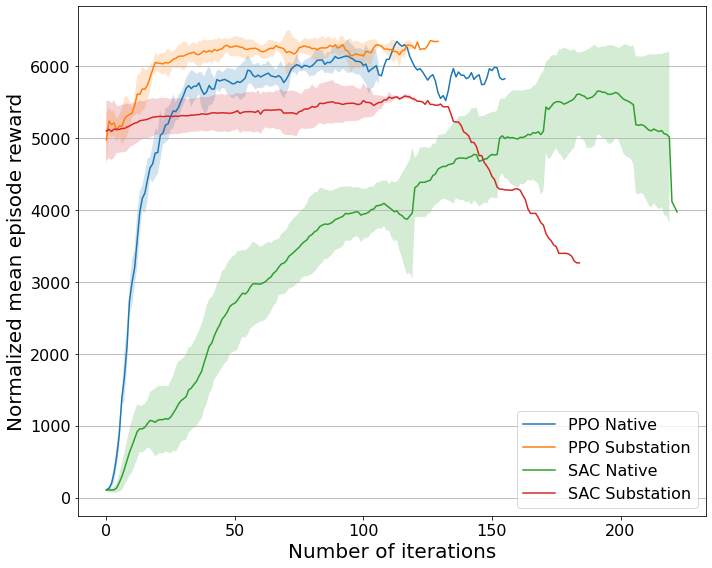

In [167]:
ax = plt.figure(figsize=(10,8), tight_layout=True)
colors = sns.color_palette('pastel')

temp_mean = df_rewards.groupby("type", dropna=False).mean().T
temp_std = df_rewards.groupby("type", dropna=False).std().T

print(temp_mean.shape, temp_std.shape)
for col in temp_mean.columns:
    val = temp_mean[col]
    val_std = temp_std[col]
    plt.plot(val.index,val)
    # ax.plot(val_std.index,val_std+val)
    # plt.fill_between(val_std.index, abs(val_std+val), abs(val_std-val), alpha=0.2)

plt.legend(list(temp_mean.columns), prop = {'size':16})

for col in temp_mean.columns:
    val = temp_mean[col]
    val_std = temp_std[col]
    # plt.plot(val.index,val)
    # ax.plot(val_std.index,val_std+val)
    plt.fill_between(val_std.index, abs(val_std+val), abs(val_std-val), alpha=0.2)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Number of iterations', size = 20)
plt.ylabel('Normalized mean episode reward', size = 20)
# plt.legend(list(temp_mean.columns), prop = {'size':16})
plt.grid(axis = "y")
plt.show()

ax.savefig("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/figures/training_reward_agents.jpg", dpi = 200)

### Looking at the variety of actions of diffiernet agent (OLD)

In [18]:
check_checkpoints = {
    0: {"agent_type": "sac",
        "checkpoint_path": "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/SAC_in_env/SAC_Grid_Gym_a77d3_00010_10_num_workers=14,seed=33_2022-02-17_20-56-11",
        "checkpoint_num": 300,
        "nb_episode" : 1
    },
    1: {"agent_type": "sac",
        "checkpoint_path": "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/SAC_in_env/SAC_Grid_Gym_a77d3_00010_10_num_workers=14,seed=33_2022-02-17_20-56-11",
        "checkpoint_num": 500,
        "nb_episode" : 1
    },
    2: {"agent_type": "sac",
        "checkpoint_path": "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/SAC_in_env/SAC_Grid_Gym_a77d3_00009_9_num_workers=12,seed=38_2022-02-18_05-14-39",
        "checkpoint_num": 250,
        "nb_episode" : 1
    },
    3: {"agent_type": "sac",
        "checkpoint_path": "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/SAC_in_env/SAC_Grid_Gym_a77d3_00009_9_num_workers=12,seed=38_2022-02-18_05-14-39",
        "checkpoint_num": 450,
        "nb_episode" : 1
    },
    4: {"agent_type": "sac",
        "checkpoint_path": "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/SAC_in_env/SAC_Grid_Gym_a77d3_00000_0_num_workers=12,seed=21_2022-02-17_20-56-11",
        "checkpoint_num": 300,
        "nb_episode" : 1
    },
    
}

chronics_to_study = [830, 61, 4, 35, 429, 664]

In [34]:

EVAL_PATHS = {#"SAC a77_0_300": "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/SAC_Grid_Gym_a77d3_00000_0_num_workers=12,seed=21_2022-02-17_20-56-11_300_5_True",
            # "SAC a77_9_450": "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/SAC_Grid_Gym_a77d3_00009_9_num_workers=12,seed=38_2022-02-18_05-14-39_450_5_True",
            # "SAC a77_9_250": "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/SAC_Grid_Gym_a77d3_00009_9_num_workers=12,seed=38_2022-02-18_05-14-39_250_5_True",
            # "SAC a77_10_500" : "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/SAC_Grid_Gym_a77d3_00010_10_num_workers=14,seed=33_2022-02-17_20-56-11_500_5_True",
            # "SAC a77_10_300" : "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/SAC_Grid_Gym_a77d3_00010_10_num_workers=14,seed=33_2022-02-17_20-56-11_300_5_True",
            "SAC_47f49_0": "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/SAC_Grid_Gym_46f49_00000_0_num_workers=2,seed=21_2022-03-04_19-09-47_540_5_True" 
            }


data_per_algorithm = {} 
for name, path in EVAL_PATHS.items():
    normalized_sub_num_actions, num_actions, actions_topo_change = get_evaluation_data(path, wandb_run_id= "a77d3_00000")
    # if name not in data_per_algorithm:
    data_per_algorithm[name] = {} 
    data_per_algorithm[name]["action_distr"] = normalized_sub_num_actions
    print(data_per_algorithm[name]["action_distr"])
    data_per_algorithm[name]["num_actions"] = num_actions
    data_per_algorithm[name]["actions_topo_change"] = actions_topo_change
    print(data_per_algorithm[name]["action_distr"])
    
    

SUBSTATION NUMBER: 0
Choosing 2 out of 3
Choosing 3 out of 3
SUBSTATION NUMBER: 1
Choosing 3 out of 6
Choosing 4 out of 6
Choosing 5 out of 6
Choosing 6 out of 6
SUBSTATION NUMBER: 2
Choosing 2 out of 4
Choosing 3 out of 4
Choosing 4 out of 4
SUBSTATION NUMBER: 3
Choosing 3 out of 6
Choosing 4 out of 6
Choosing 5 out of 6
Choosing 6 out of 6
SUBSTATION NUMBER: 4
Choosing 3 out of 5
Choosing 4 out of 5
Choosing 5 out of 5
SUBSTATION NUMBER: 5
Choosing 3 out of 6
Choosing 4 out of 6
Choosing 5 out of 6
Choosing 6 out of 6
SUBSTATION NUMBER: 6
Choosing 2 out of 3
Choosing 3 out of 3
SUBSTATION NUMBER: 7
Choosing 1 out of 2
Choosing 2 out of 2
SUBSTATION NUMBER: 8
Choosing 3 out of 5
Choosing 4 out of 5
Choosing 5 out of 5
SUBSTATION NUMBER: 9
Choosing 2 out of 3
Choosing 3 out of 3
SUBSTATION NUMBER: 10
Choosing 2 out of 3
Choosing 3 out of 3
SUBSTATION NUMBER: 11
Choosing 2 out of 3
Choosing 3 out of 3
SUBSTATION NUMBER: 12
Choosing 2 out of 4
Choosing 3 out of 4
Choosing 4 out of 4
SUBS

Exception ignored in: <function GymEnv.__del__ at 0x7f89dac6a9e0>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 81, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


Normalized substation actions {'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.0, '8': 0.007947976878612716, '12': 0.0, 'Implict No op': 0.9920520231213873, 'Explicit No op': 0.0}
{'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.0, '8': 0.007947976878612716, '12': 0.0, 'Implict No op': 0.9920520231213873, 'Explicit No op': 0.0}
{'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.0, '8': 0.007947976878612716, '12': 0.0, 'Implict No op': 0.9920520231213873, 'Explicit No op': 0.0}


In [5]:
from collections import defaultdict
from evaluation.run_eval import EvaluationRunner
import numpy as np

def eval_loop(agent, chronics_to_study = chronics_to_study):
    actions_ = defaultdict(list)
    topo_vects_ = defaultdict(list) 
    chronic_to_num_steps_ = defaultdict(int) 


    for chronic_id in chronics_to_study:
        agent.env.set_id(chronic_id)

        if int(agent.env.chronics_handler.get_name()) > len(agent.env.chronics_handler.subpaths): 
            raise ValueError("Chronics id is too high")
        assert int(agent.env.chronics_handler.get_name()) == chronic_id-1, "Chronics id is not the same as the one in the environment"
        
        done = False
        num_steps = 0
        obs = agent.env.reset()
        add_obs = False
        
        while not done:
            num_steps += 1
            act = agent.wrapped_agent.act(obs)
            if obs.rho.max() > agent.env_config["rho_threshold"]: # save action taken above the threshold
                add_obs = True
                actions_[chronic_id].append(act)
                # break
                
            obs, reward, done, info = agent.env.step(act)

            if add_obs: # save topo vector resulting from action above the threshold
                topo_vects_[chronic_id].append(obs.topo_vect)
                add_obs = False

        chronic_to_num_steps_[chronic_id] = num_steps

    return actions_, topo_vects_, chronic_to_num_steps_



/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [3]:
agent = EvaluationRunner(**check_checkpoints[0])  

Evaluating the following chronics [1]
[LOG]: 2022-03-04:12:20:40,557 INFO     [/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/restore_agent.py:79 in     function restore_agent] Restoring checkpoint 300 from /Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/SAC_in_env/SAC_Grid_Gym_a77d3_00010_10_num_workers=14,seed=33_2022-02-17_20-56-11/checkpoint_000300/checkpoint-300
Config params:  {'env': "<class 'grid2op_env.grid_to_gym.Grid_Gym'>", 'env_config': {'act_on_single_substation': True, 'combine_rewards': False, 'convert_to_tuple': True, 'env_name': 'rte_case14_realistic', 'keep_actions': ['change_bus'], 'keep_observations': ['rho', 'gen_p', 'load_p', 'p_or', 'p_ex', 'timestep_overflow', 'maintenance', 'topo_vect'], 'log_reward': False, 'medha_actions': True, 'reward_scaling_factor': 3, 'rho_threshold': 0.95, 'run_until_threshold': True, 'scale': True, 'use_parametric': False}, 'framework': 'torch', 'learning_starts': 2048, 'log_le

(RolloutWorker pid=52262) 2022-03-04 12:20:52,008	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)
(RolloutWorker pid=52260) 2022-03-04 12:20:51,952	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)
(RolloutWorker pid=52260) 2022-03-04 12:20:52,013	INFO torch_policy.py:165 -- TorchPolicy (worker=3) running on CPU.
2022-03-04 12:20:52,117	INFO worker_set.py:104 -- Inferred observation/action spaces from remote worker (local worker has no env): {'default_policy': (Dict(gen_p:Box([-0.0514     -0.03855    -0.11014286 -0.1542     -0.0257    ], [1.0514    1.0385499 1.1101428 1.1542    1.0257001], (5,), float32), load_p:Box([-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf inf inf inf], (11,), float32), p_ex:Box([-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf], (

SUBSTATION NUMBER: 0
Choosing 2 out of 3
Choosing 3 out of 3
SUBSTATION NUMBER: 1
Choosing 3 out of 6
Choosing 4 out of 6
Choosing 5 out of 6
Choosing 6 out of 6
SUBSTATION NUMBER: 2
Choosing 2 out of 4
Choosing 3 out of 4
Choosing 4 out of 4
SUBSTATION NUMBER: 3
Choosing 3 out of 6
Choosing 4 out of 6
Choosing 5 out of 6
Choosing 6 out of 6
SUBSTATION NUMBER: 4
Choosing 3 out of 5
Choosing 4 out of 5
Choosing 5 out of 5
SUBSTATION NUMBER: 5
Choosing 3 out of 6
Choosing 4 out of 6
Choosing 5 out of 6
Choosing 6 out of 6
SUBSTATION NUMBER: 6
Choosing 2 out of 3
Choosing 3 out of 3
SUBSTATION NUMBER: 7
Choosing 1 out of 2
Choosing 2 out of 2
SUBSTATION NUMBER: 8
Choosing 3 out of 5
Choosing 4 out of 5
Choosing 5 out of 5
SUBSTATION NUMBER: 9
Choosing 2 out of 3
Choosing 3 out of 3
SUBSTATION NUMBER: 10
Choosing 2 out of 3
Choosing 3 out of 3
SUBSTATION NUMBER: 11
Choosing 2 out of 3
Choosing 3 out of 3
SUBSTATION NUMBER: 12
Choosing 2 out of 4
Choosing 3 out of 4
Choosing 4 out of 4
SUBS

In [29]:
# actions_, topo_vects_, chronic_to_num_steps_ = eval_loop(agent)
action_analysis = ActionAnalysis(actions_)

In [33]:
action_analysis.

In [6]:
for key in check_checkpoints.keys():
    print("key: ", key)
    try:
        agent = EvaluationRunner(**check_checkpoints[key])  
        actions_, topo_vects_, chronic_to_num_steps_ = eval_loop(agent)
        action_analysis = ActionAnalysis(actions_)
        check_checkpoints[key]["action_analysis"] = action_analysis
        check_checkpoints[key]["topo_vects"] = topo_vects_
        check_checkpoints[key]["chronic_to_num_steps"] = chronic_to_num_steps_
    except Exception as e:
        print("key: ", key, "Exception: ", e, flush=True)

        continue

key:  0
Evaluating the following chronics [1]
[LOG]: 2022-03-04:12:55:23,334 INFO     [/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/restore_agent.py:79 in     function restore_agent] Restoring checkpoint 300 from /Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/SAC_in_env/SAC_Grid_Gym_a77d3_00010_10_num_workers=14,seed=33_2022-02-17_20-56-11/checkpoint_000300/checkpoint-300
Config params:  {'env': "<class 'grid2op_env.grid_to_gym.Grid_Gym'>", 'env_config': {'act_on_single_substation': True, 'combine_rewards': False, 'convert_to_tuple': True, 'env_name': 'rte_case14_realistic', 'keep_actions': ['change_bus'], 'keep_observations': ['rho', 'gen_p', 'load_p', 'p_or', 'p_ex', 'timestep_overflow', 'maintenance', 'topo_vect'], 'log_reward': False, 'medha_actions': True, 'reward_scaling_factor': 3, 'rho_threshold': 0.95, 'run_until_threshold': True, 'scale': True, 'use_parametric': False}, 'framework': 'torch', 'learning_starts': 2048,

(RolloutWorker pid=67928) 2022-03-04 12:55:34,205	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)
(RolloutWorker pid=67928) 2022-03-04 12:55:34,241	INFO torch_policy.py:165 -- TorchPolicy (worker=2) running on CPU.
(RolloutWorker pid=67940) 2022-03-04 12:55:34,339	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)
(RolloutWorker pid=67940) 2022-03-04 12:55:34,373	INFO torch_policy.py:165 -- TorchPolicy (worker=1) running on CPU.
(RolloutWorker pid=67932) 2022-03-04 12:55:34,348	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)
(RolloutWorker pid=67932) 2022-03-04 12:55:34,392	INFO torch_policy.py:165 -- TorchPolicy (worker=6) running on CPU.
(RolloutWorker pid=67940) 2022-03-04 12:55:34,391	WARNING deprecation.py:46 -- DeprecationWarning: `convert_to_non_torch_type` has been deprecated. Use `ray/rllib/utils/numpy.py::convert_to_numpy` instead. This will raise an error in the future!
2022-03-04 12:55:34,43

(scheduler +23s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(scheduler +23s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
SUBSTATION NUMBER: 0
Choosing 2 out of 3
Choosing 3 out of 3
SUBSTATION NUMBER: 1
Choosing 3 out of 6
Choosing 4 out of 6
Choosing 5 out of 6
Choosing 6 out of 6
SUBSTATION NUMBER: 2
Choosing 2 out of 4
Choosing 3 out of 4
Choosing 4 out of 4
SUBSTATION NUMBER: 3
Choosing 3 out of 6
Choosing 4 out of 6
Choosing 5 out of 6
Choosing 6 out of 6
SUBSTATION NUMBER: 4
Choosing 3 out of 5
Choosing 4 out of 5
Choosing 5 out of 5
SUBSTATION NUMBER: 5
Choosing 3 out of 6
Choosing 4 out of 6
Choosing 5 out of 6
Choosing 6 out of 6
SUBSTATION NUMBER: 6
Choosing 2 out of 3
Choosing 3 out of 3
SUBSTATION NUMBER: 7
Choosing 1 out of 2
C

2022-03-04 12:55:38,016	WARNING deprecation.py:46 -- DeprecationWarning: `compute_action` has been deprecated. Use `compute_single_action` instead. This will raise an error in the future!
2022-03-04 12:55:44,801	WARNING worker.py:1245 -- The actor or task with ID ffffffffffffffff9b480294ff35cdc78cc182af01000000 cannot be scheduled right now. You can ignore this message if this Ray cluster is expected to auto-scale or if you specified a runtime_env for this actor or task, which may take time to install.  Otherwise, this is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increasing the resources available to this Ray cluster.
Required resources for this actor or task: {CPU: 1.000000}
Available resources on this node: {0.000000/8.000000 CPU, 455996520.068359 GiB/455996520.068359 GiB memory, 227998259.960938 GiB/227998259.960938 GiB object_store_memory, 1.000000/1.000000 node:127.0.0.1}
 In total there are 0 pending tasks

(scheduler +58s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
key:  1
Evaluating the following chronics [1]
[LOG]: 2022-03-04:12:56:27,374 INFO     [/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/restore_agent.py:79 in     function restore_agent] Restoring checkpoint 500 from /Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/SAC_in_env/SAC_Grid_Gym_a77d3_00010_10_num_workers=14,seed=33_2022-02-17_20-56-11/checkpoint_000500/checkpoint-500
Config params:  {'env': "<class 'grid2op_env.grid_to_gym.Grid_Gym'>", 'env_config': {'act_on_single_substation': True, 'combine_rewards': False, 'convert_to_tuple': True, 'env_name': 'rte_case14_realistic', 'keep_actions': ['change_bus'], 'keep_observations': ['rho', 'gen_p', 'load_p', 'p_or', 'p_ex', 'timestep_overflo

KeyboardInterrupt: 

(scheduler +54m46s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +55m21s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +55m57s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +56m32s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +

In [38]:
 check_checkpoints

{0: {'agent_type': 'sac',
  'checkpoint_path': '/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/SAC_in_env/SAC_Grid_Gym_a77d3_00010_10_num_workers=14,seed=33_2022-02-17_20-56-11',
  'checkpoint_num': 300,
  'nb_episode': 1},
 1: {'agent_type': 'sac',
  'checkpoint_path': '/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/SAC_in_env/SAC_Grid_Gym_a77d3_00010_10_num_workers=14,seed=33_2022-02-17_20-56-11',
  'checkpoint_num': 500,
  'nb_episode': 1},
 2: {'agent_type': 'sac',
  'checkpoint_path': '/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/SAC_in_env/SAC_Grid_Gym_a77d3_00009_9_num_workers=12,seed=38_2022-02-18_05-14-39',
  'checkpoint_num': 250,
  'nb_episode': 1},
 3: {'agent_type': 'sac',
  'checkpoint_path': '/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/SAC_in_env/SAC_Grid_Gym_a77d3_00009_9_num_workers=12,seed=38_2022-02-18_05-14-39',
  'checkpoint_num': 250,
  'nb_epis

(scheduler +31m59s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +32m34s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +33m9s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +33m44s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


In [30]:


grouped = action_analysis.action_to_sub_id(action_analysis.actions) # needed for explicit do nothing
        grouped_topo_change = action_analysis.action_to_sub_id(action_analysis.actions_topo_change)

        sub_num_actions = action_analysis.substation_count(grouped_topo_change)
        sub_num_actions_all = action_analysis.substation_count(grouped)

        sub_num_actions["10000"] = abs(sub_num_actions_all["0"] - \
                (action_analysis.count_actions(action_analysis.actions) -  action_analysis.count_actions(action_analysis.actions_topo_change)))

(array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32),
 array([236]))

(scheduler +15m2s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +15m37s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +16m12s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


In [32]:
check_checkpoints[0]["unique_topos"] = action_analysis.get_unique_topos(topo_vects_)

(scheduler +16m47s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


In [19]:

all_topos = []
for chronic in topo_vects_.keys():
    all_topos.append(topo_vects_[chronic])

np.concatenate(all_topos).shape #, return_counts=True)

(236, 56)

In [20]:
np.unique(np.concatenate(all_topos), axis = 0) .shape

(1, 56)

(scheduler +4m30s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


In [56]:
for key in actions_:
    for act in actions_[key]:
        print(act.as_dict()["set_bus_vect"]["modif_subs_id"])

['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
(scheduler +4m0s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to

In [60]:
list(act.as_dict().items()) #["set_bus_vect"]["modif_subs_id"]

[('set_bus_vect',
  {'nb_modif_objects': 7,
   '8': {'10': {'type': 'line (origin)', 'new_bus': 1},
    '11': {'type': 'line (origin)', 'new_bus': 1},
    '16': {'type': 'line (extremity)', 'new_bus': 1},
    '19': {'type': 'line (origin)', 'new_bus': 2},
    '5': {'type': 'load', 'new_bus': 2}},
   'nb_modif_subs': 1,
   'modif_subs_id': ['8']})]

(scheduler +10m26s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


# Looking again at the evluation runner

In [1]:
from evaluation.run_eval import EvaluationRunner

/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [2]:
sac_greedy = EvaluationRunner(agent_type = "sac",
                         checkpoint_path="/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/SAC_greedy_substation/SAC_Grid_Gym_Greedy_02837_00009_9_num_workers=4,seed=28,train_batch_size=1024_2022-02-25_15-25-36/",
                         #checkpoint_path = "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/SAC_greedy_substation/SAC_Grid_Gym_Greedy_02837_00001_1_num_workers=2,seed=49,train_batch_size=1024_2022-02-25_13-32-49",
                            #checkpoint_num= 320,
                            checkpoint_num= 100,
                             nb_episode= 1000
                            )  

Evaluating the following chronics [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215

(RolloutWorker pid=93866) 2022-03-02 14:05:27,320	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)
(RolloutWorker pid=93866) 2022-03-02 14:05:27,359	INFO torch_policy.py:165 -- TorchPolicy (worker=2) running on CPU.
(RolloutWorker pid=93861) 2022-03-02 14:05:27,425	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)
2022-03-02 14:05:27,498	INFO worker_set.py:104 -- Inferred observation/action spaces from remote worker (local worker has no env): {'default_policy': (Dict(gen_p:Box([-0.0514     -0.03855    -0.11014286 -0.1542     -0.0257    ], [1.0514    1.0385499 1.1101428 1.1542    1.0257001], (5,), float32), load_p:Box([-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf inf inf inf], (11,), float32), p_ex:Box([-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf], (

Using greedy agent
SUBSTATION NUMBER: 0
Choosing 2 out of 3
Choosing 3 out of 3
SUBSTATION NUMBER: 1
Choosing 3 out of 6
Choosing 4 out of 6
Choosing 5 out of 6
Choosing 6 out of 6
SUBSTATION NUMBER: 2
Choosing 2 out of 4
Choosing 3 out of 4
Choosing 4 out of 4
SUBSTATION NUMBER: 3
Choosing 3 out of 6
Choosing 4 out of 6
Choosing 5 out of 6
Choosing 6 out of 6
SUBSTATION NUMBER: 4
Choosing 3 out of 5
Choosing 4 out of 5
Choosing 5 out of 5
SUBSTATION NUMBER: 5
Choosing 3 out of 6
Choosing 4 out of 6
Choosing 5 out of 6
Choosing 6 out of 6
SUBSTATION NUMBER: 6
Choosing 2 out of 3
Choosing 3 out of 3
SUBSTATION NUMBER: 7
Choosing 1 out of 2
Choosing 2 out of 2
SUBSTATION NUMBER: 8
Choosing 3 out of 5
Choosing 4 out of 5
Choosing 5 out of 5
SUBSTATION NUMBER: 9
Choosing 2 out of 3
Choosing 3 out of 3
SUBSTATION NUMBER: 10
Choosing 2 out of 3
Choosing 3 out of 3
SUBSTATION NUMBER: 11
Choosing 2 out of 3
Choosing 3 out of 3
SUBSTATION NUMBER: 12
Choosing 2 out of 4
Choosing 3 out of 4
Choos

In [3]:
sac_greedy.env_config

{'act_on_single_substation': True,
 'conn_matrix': False,
 'convert_to_tuple': True,
 'disable_line': -1,
 'env_name': 'rte_case14_realistic',
 'greedy_agent': True,
 'keep_actions': ['change_bus'],
 'keep_observations': ['rho',
  'gen_p',
  'load_p',
  'p_or',
  'p_ex',
  'timestep_overflow',
  'maintenance',
  'topo_vect'],
 'log_reward': False,
 'medha_actions': True,
 'reward_scaling_factor': 3,
 'rho_threshold': 0.95,
 'run_until_threshold': True,
 'scale': True,
 'substation_actions': True,
 'use_parametric': False}

In [7]:
from collections import defaultdict
actions_ = defaultdict(list)
topo_vects_ = defaultdict(list) 
chronic_to_num_steps_ = defaultdict(int) 

chronics_to_study = [2,5,6,7,8,121]
for chronic_id in chronics_to_study:
    sac_greedy.env.set_id(chronic_id)

    if int(sac_greedy.env.chronics_handler.get_name()) > len(sac_greedy.env.chronics_handler.subpaths): 
        raise ValueError("Chronics id is too high")
    assert int(sac_greedy.env.chronics_handler.get_name()) == chronic_id-1, "Chronics id is not the same as the one in the environment"
    
    done = False
    num_steps = 0
    obs = sac_greedy.env.reset()
    add_obs = False
    
    while not done:
        num_steps += 1
        act = sac_greedy.wrapped_agent.act(obs)
        if obs.rho.max() > sac_greedy.env_config["rho_threshold"]: # save action taken above the threshold
            add_obs = True
            actions_[chronic_id].append(act)
            # break
            
        obs, reward, done, info = sac_greedy.env.step(act)

        if add_obs: # save topo vector resulting from action above the threshold
            topo_vects_[chronic_id].append(obs.topo_vect)
            add_obs = False

    chronic_to_num_steps_[chronic_id] = num_steps

In [8]:
chronic_to_num_steps_

defaultdict(int, {2: 8064, 5: 8064, 6: 8064, 7: 8064, 8: 8064, 121: 8064})

In [9]:
for key in actions_:
    for act in actions_[key]:
        print(act.as_dict()["set_bus_vect"]["modif_subs_id"])

['4']
['4']
['4']
['4']
['8']
['4']
['4']
['4']
['4']
['4']
['8']
['4']
['8']
['8']
['4']
['4']
['4']
['8']
['8']
['4']
['8']
['4']
['8']
['8']
['8']
['8']
['4']
['8']
['4']
['8']
['4']
['4']
['4']
['4']
['8']
['8']
['8']
['8']
['4']
['4']
['4']
['8']
['8']
['8']
['4']
['8']
['4']
['4']
['8']
['8']
['4']
['8']
['4']
['4']
['4']
['8']
['8']
['4']
['8']
['4']
['4']
['8']
['4']
['4']
['4']
['8']
['4']
['4']
['8']
['4']
['4']
['4']
['4']
['4']
['4']
['4']
['4']
['8']
['8']
['4']
['4']
['4']
['4']
['4']
['8']
['8']
['4']
['8']
['4']
['8']
['8']
['4']
['8']
['4']
['4']
['4']
['4']
['4']
['4']
['8']
['8']
['4']
['4']
['4']
['4']
['8']
['4']
['8']
['4']
['4']
['4']
['4']
['4']
['4']
['4']
['8']
['4']
['4']
['4']
['8']
['8']
['4']
['8']
['8']
['4']
['4']
['4']
['4']
['4']
['4']
['8']
['4']
['4']
['8']
['4']
['1']
['4']
['4']
['8']
['4']
['8']
['8']
['4']
['4']
['4']
['8']
['8']
['8']
['8']
['8']
['8']
['4']
['4']
['4']
['4']
['8']
['8']
['4']
['4']
['8']
['4']
['4']
['8']
['8']
['8']
['4']
['8'

In [42]:
from scipy.special import softmax
import numpy as np


policy = sac_greedy.wrapped_agent.trained_agent.get_policy()
#sac_greedy.wrapped_agent.trained_agent.compute_action(gym_obs, full_fetch = True)[2]["action_dist_inputs"]

gym_obs = sac_greedy.rllib_env.obs_grid2rllib(obs)

In [43]:
gym_obs["rho"]#[0:5] = 1.5

array([0.19192156, 0.16847098, 0.118008  , 0.18152764, 0.15083955,
       0.07890058, 0.13962805, 0.5924088 , 0.65178216, 0.95271647,
       0.15488522, 0.642221  , 0.4157636 , 0.20923541, 0.43945292,
       0.34165204, 0.17046945, 0.39150107, 0.517177  , 0.3897603 ],
      dtype=float32)

In [44]:
inp = []
import torch
for key,val in gym_obs.items():
    inp.append(torch.from_numpy(val))

inp = torch.cat(inp)

In [45]:
inp

#torch.rand_like(inp)

tensor([5.8933e-01, 4.3250e-01, 3.0714e-01, 0.0000e+00, 2.8560e-01, 6.7503e-01,
        6.7300e-01, 6.4093e-01, 7.4653e-01, 7.9736e-01, 7.2120e-01, 7.0621e-01,
        7.4275e-01, 6.8565e-01, 6.6855e-01, 7.4074e-01, 3.4852e-01, 3.2097e-01,
        4.1728e-01, 3.0175e-01, 3.1839e-01, 3.3289e-01, 5.8206e-01, 6.0484e-01,
        7.1852e-01, 2.9404e-01, 3.4325e-01, 6.2493e-01, 3.1013e-01, 8.9270e-01,
        4.4755e-01, 3.3934e-01, 3.3966e-01, 3.4276e-01, 3.7743e-15, 5.7478e-01,
        6.4985e-01, 6.7555e-01, 5.7944e-01, 6.9454e-01, 6.7840e-01, 6.6203e-01,
        4.1683e-01, 3.9285e-01, 2.7515e-01, 7.0628e-01, 6.5528e-01, 3.6474e-01,
        6.8811e-01, 1.0279e-01, 5.5127e-01, 6.6066e-01, 6.6034e-01, 6.5724e-01,
        1.0000e+00, 4.2522e-01, 1.9192e-01, 1.6847e-01, 1.1801e-01, 1.8153e-01,
        1.5084e-01, 7.8901e-02, 1.3963e-01, 5.9241e-01, 6.5178e-01, 9.5272e-01,
        1.5489e-01, 6.4222e-01, 4.1576e-01, 2.0924e-01, 4.3945e-01, 3.4165e-01,
        1.7047e-01, 3.9150e-01, 5.1718e-

In [46]:
past_inp = torch.Tensor([5.9267e-01, 4.2950e-01, 4.7000e-01, 0.0000e+00, 2.7940e-01, 7.1685e-01,
7.3011e-01, 6.0907e-01, 7.1181e-01, 7.4940e-01, 7.6737e-01, 7.2740e-01,
7.7899e-01, 7.4895e-01, 6.7797e-01, 7.3633e-01, 3.9518e-01, 3.0088e-01,
4.2065e-01, 4.2344e-01, 2.4795e-01, 5.4461e-01, 8.4435e-01, 5.6398e-01,
7.0481e-01, 2.6614e-01, 3.7344e-01, 6.5125e-01, 3.5067e-01, 8.9954e-01,
4.2084e-01, 3.2909e-01, 3.2674e-01, 4.7044e-01, 3.8106e-15, 5.8383e-01,
6.0292e-01, 6.9728e-01, 5.7605e-01, 5.7135e-01, 7.5224e-01, 4.4735e-01,
1.5899e-01, 4.3251e-01, 2.8865e-01, 7.3385e-01, 6.2504e-01, 3.3944e-01,
6.4652e-01, 9.6136e-02, 5.7642e-01, 6.7091e-01, 6.7326e-01, 5.2956e-01,
1.0000e+00, 4.1617e-01, 1.7842e-01, 1.7836e-01, 1.1734e-01, 1.5395e-01,
1.7508e-01, 2.9104e-02, 2.5522e-01, 5.8353e-01, 6.7476e-01, 9.5974e-01,
1.2524e-01, 6.5722e-01, 3.9752e-01, 1.8623e-01, 4.2221e-01, 3.0761e-01,
1.6887e-01, 3.4670e-01, 4.0924e-01, 4.0209e-01, 0.0000e+00, 0.0000e+00,
0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
1.0000e+00, 1.0000e+00])

In [51]:


# logits, _ = policy.model({"obs": gym_obs})#.from_batch({"obs": gym_obs})
dist = policy.model.get_policy_output(past_inp.unsqueeze(0))

#dist = policy.model.get_policy_output(torch.rand_like(inp).unsqueeze(0))


In [52]:
softmax(dist.detach().numpy()) #, softmax(torch.rand_like(inp))

array([[2.8367515e-06, 7.4906605e-03, 8.6640381e-07, 9.9034047e-01,
        1.6398284e-03, 1.6252393e-07, 5.2436738e-04, 8.5684087e-07]],
      dtype=float32)

(scheduler +20m37s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +21m12s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +21m47s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +22m22s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +

In [6]:
obs.p_ex

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [6]:
for act in actions_[5]:
    print(act.as_dict()["set_bus_vect"]["modif_subs_id"])


['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8']
['8'

In [132]:
data_per_algorithm = {} #defaultdict(object)

data_per_algorithm[EVAL_RESULTS_PATH] = {} 

data_per_algorithm[EVAL_RESULTS_PATH]["action_distr"] = normalized_sub_num_actions
data_per_algorithm[EVAL_RESULTS_PATH]["num_actions"] = num_actions


In [133]:
EVAL_PATHS = [
    
    
]

KeyError: 'action_distr'

In [121]:
normalized_sub_num_actions

{'1': 0.004100823699932831,
 '2': 0.0,
 '3': 0.3363912751440591,
 '4': 0.0,
 '5': 3.5351928447696824e-05,
 '8': 0.03036730653657157,
 '12': 0.0,
 'Implict No op': 0.6287693993707357,
 'Explicit No op': 0.0003358433202531198}

In [112]:
sub_num_actions

{'1': 232,
 '2': 0,
 '3': 19031,
 '4': 0,
 '5': 2,
 '8': 1718,
 '12': 0,
 'Implict No op': 35572,
 'Explicit No op': 19}

In [99]:
num_actions = sum(sub_num_actions.values())
normalized_sub_num_actions = {key: value/num_actions for key, value in sub_num_actions.items()}

In [113]:
normalized_sub_num_actions

{'1': 0.004100823699932831,
 '2': 0.0,
 '3': 0.3363912751440591,
 '4': 0.0,
 '5': 3.5351928447696824e-05,
 '8': 0.03036730653657157,
 '12': 0.0,
 'Implict No op': 0.6287693993707357,
 'Explicit No op': 0.0003358433202531198}

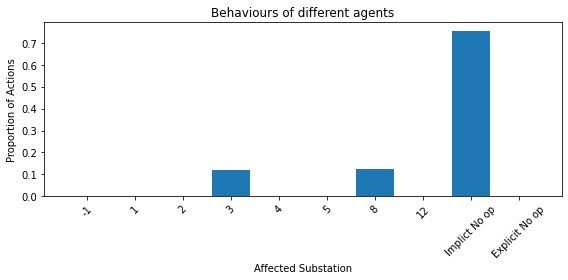

In [33]:
len(topo_vects) , len(actions)

for key in topo_vects.keys():
    if len(topo_vects[key]) != len(actions[key]):
        print( f"Key {key} has {len(topo_vects[key])} topo vects and {len(actions[key])} actions")

Key 40 has 49 topo vects and 50 actions
Key 145 has 9 topo vects and 10 actions
Key 335 has 86 topo vects and 87 actions
Key 486 has 14 topo vects and 15 actions
Key 528 has 137 topo vects and 138 actions
Key 541 has 125 topo vects and 126 actions
Key 768 has 159 topo vects and 160 actions
Key 792 has 101 topo vects and 100 actions
Key 972 has 20 topo vects and 19 actions
Key 977 has 56 topo vects and 57 actions


In [34]:
aa.pop_implicit_no_op(topo_vects)

In [141]:
aa.count_actions(aa.actions), aa.count_actions(aa.actions_topo_change)#, aa.count_actions(aa.actions_topo_change2)

(56555, 20983)

In [46]:
grouped = aa.action_to_sub_id(aa.actions)
#grouped_topo_change = aa.action_to_sub_id(aa.actions_topo_change)
#grouped_topo_change2 = aa.action_to_sub_id(aa.actions_topo_change2)

In [53]:
aa.substation_count(grouped_topo_change)#.keys()

defaultdict(int, {'8': 1718, '3': 19031, '1': 232, '5': 2})

In [55]:
aa.substation_count(grouped)

defaultdict(int, {'8': 18806, '3': 37373, '1': 336, '4': 18, '0': 19, '5': 3})

In [ ]:
def preprocess_sub_dict(sub_grouped, sub_grouped_topo_change, do_nothing_actions):
    sub_grouped_topo_change["No op"] = len(grouped) - len(grouped_topo_change)
    grouped_topo_change["No op"] += grouped_topo_change[do_nothing_actions[0]]

    keys 
    grouped_topo_change.pop(do)


In [ ]:
from typing import Optional, List

def plot_sub_dist(grouped: Dict[int, List[int]], all_subs: Optional[List] = None) -> None:
    """
    Plots the distribution of substations affected by each action.

    Parameters:
    -----------
    grouped: Dict[int, List[int]]
        Output of action_to_sub_id method.
    """
    count = defaultdict(int)
    for k, v in grouped.items():
        for sub in v:
            count[sub] += 1
    plt.bar(list(count.keys()), list(count.values()))
    plt.show()

In [143]:
# len(grouped_topo_change[3]),  len(grouped[3]) #, len(grouped_topo_change2[3])
# (np.diff(np.array(topo_vects[3]), axis = 0) != 0 ).any(axis = 1)
# for i, act in enumerate(aa.actions[3]):
#     if i == 0:
#         continue
#     if aa.actions[3][i-1].as_dict() == act.as_dict():
#         print(f"{i-1} is the same as {i}")
    

(6, 7)

In [42]:
import seaborn as sns

sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes


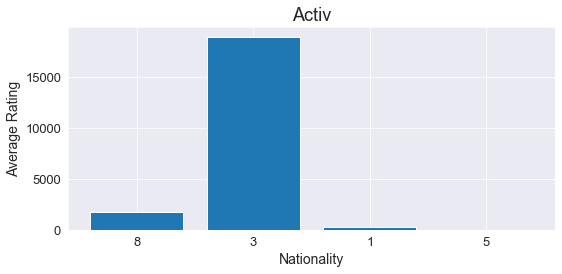

In [45]:
plot_dic = aa.substation_count(grouped_topo_change)

plt.figure(figsize=(8,4), tight_layout=True)
colors = sns.color_palette('pastel')

#plt.bar(barplot['nationality'], barplot['overall'], color=colors[:5])
plt.bar([str(val) for val in plot_dic.keys()] , list(plot_dic.values()))
plt.xlabel('Nationality')
plt.ylabel('Average Rating')
plt.title('Activ')
plt.show()

<BarContainer object of 4 artists>

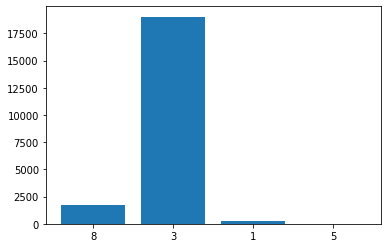

In [151]:


import matplotlib.pyplot as plt


plt.bar([str(val) for val in plot_dic.keys()] , list(plot_dic.values()))

In [45]:
aa.substation_count(grouped)

defaultdict(int,
            {'8': 1702,
             '1': 8350,
             '4': 4041,
             '3': 5099,
             '0': 12203,
             '5': 483,
             '2': 200,
             '12': 544})

<BarContainer object of 8 artists>

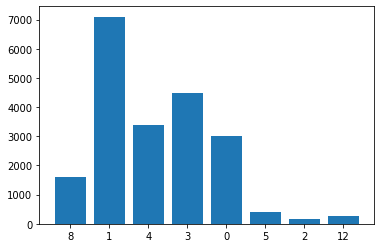

In [43]:
plot_dic = aa.substation_count(grouped_topo_change)

import matplotlib.pyplot as plt


plt.bar([str(val) for val in plot_dic.keys()] , list(plot_dic.values()))

<BarContainer object of 8 artists>

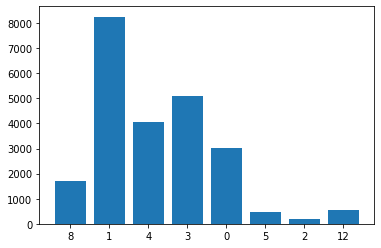

In [44]:


plot_dic = aa.substation_count(grouped_topo_change2)

import matplotlib.pyplot as plt


plt.bar([str(val) for val in plot_dic.keys()] , list(plot_dic.values()))

In [201]:
[act.as_dict() for act in actions[1]]

[{'set_bus_vect': {'nb_modif_objects': 3,
   '0': {'0': {'type': 'line (origin)', 'new_bus': 1},
    '1': {'type': 'line (origin)', 'new_bus': 1},
    '4': {'type': 'generator', 'new_bus': 1}},
   'nb_modif_subs': 1,
   'modif_subs_id': ['0']}},
 {'set_bus_vect': {'nb_modif_objects': 3,
   '0': {'0': {'type': 'line (origin)', 'new_bus': 1},
    '1': {'type': 'line (origin)', 'new_bus': 1},
    '4': {'type': 'generator', 'new_bus': 1}},
   'nb_modif_subs': 1,
   'modif_subs_id': ['0']}},
 {'set_bus_vect': {'nb_modif_objects': 8,
   '3': {'3': {'type': 'line (extremity)', 'new_bus': 2},
    '5': {'type': 'line (extremity)', 'new_bus': 1},
    '6': {'type': 'line (origin)', 'new_bus': 1},
    '15': {'type': 'line (origin)', 'new_bus': 1},
    '16': {'type': 'line (origin)', 'new_bus': 1},
    '2': {'type': 'load', 'new_bus': 2}},
   'nb_modif_subs': 1,
   'modif_subs_id': ['3']}}]

In [202]:
[topo for topo in topo_vects[1]]

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)]

In [203]:
topo_vects[1][1] - topo_vects[1][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [204]:
topo_vects[1][2] - topo_vects[1][1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [89]:
aa.action_to_sub_id()

defaultdict(list,
            {1: [-1,
              -1,
              -1,
              -1,
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              -1,
              -1,
              -1,
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              -1,
              -1,
              ['3'],
              -1,
              -1,
              -1,
              -1,
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              ['3'],
              -1,
             

In [73]:
{key:len(val) for key,val in aa.order_chronics_per_activity().items()}

{99: 476,
 824: 475,
 69: 413,
 655: 411,
 60: 389,
 465: 378,
 32: 368,
 21: 365,
 520: 361,
 730: 360,
 434: 356,
 179: 344,
 819: 344,
 861: 342,
 85: 334,
 429: 333,
 46: 326,
 650: 314,
 128: 311,
 427: 304,
 886: 304,
 891: 302,
 422: 296,
 716: 296,
 841: 296,
 367: 292,
 446: 290,
 979: 290,
 509: 288,
 981: 285,
 810: 281,
 146: 275,
 856: 273,
 353: 271,
 630: 268,
 680: 268,
 517: 266,
 239: 265,
 887: 265,
 380: 264,
 947: 263,
 161: 262,
 79: 261,
 400: 261,
 376: 259,
 418: 258,
 134: 257,
 614: 257,
 643: 256,
 8: 254,
 949: 253,
 137: 252,
 268: 251,
 426: 251,
 303: 250,
 347: 250,
 573: 249,
 396: 247,
 637: 247,
 955: 246,
 130: 243,
 395: 241,
 431: 240,
 924: 240,
 153: 237,
 834: 235,
 381: 234,
 480: 234,
 954: 234,
 538: 232,
 651: 231,
 740: 228,
 255: 227,
 812: 227,
 142: 226,
 240: 226,
 147: 224,
 708: 224,
 952: 223,
 92: 222,
 43: 220,
 900: 217,
 156: 214,
 995: 214,
 672: 211,
 608: 210,
 794: 210,
 231: 209,
 783: 208,
 541: 206,
 767: 206,
 568: 204,


In [76]:
actions[1][0]

In [ ]:
import numpy as np

a = np.random.randint(0, 255, size=(32,32,3))